In [1]:
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import collections
import pickle
import argparse
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.tokenize import word_tokenize
from tensorflow.contrib import rnn
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing import sequence
import os
print(os.listdir("../"))

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['ubuntu']


Using TensorFlow backend.


In [3]:
data = pd.read_json('~/test_data.json', lines=True)
data.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [5]:
cates = data.groupby('category')
print("There are:", cates.ngroups, "category")
print(cates.size())

There are: 41 category
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOS

In [6]:
data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [7]:

# Change the text to tokens.
data['text'] = data.headline + " " + data.short_description
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
X = tokenizer.texts_to_sequences(data.text)
data['words'] = X

data['word_length'] = data.words.apply(lambda i: len(i))
data = data[data.word_length >= 5]

data.head()

,authors,category,date,headline,link,short_description,text,words,word_length
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26


In [10]:
data.word_length.describe()

count    199914.000000
mean         29.725032
std          14.024717
min           5.000000
25%          20.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

In [11]:
maxlen = 50
X = list(sequence.pad_sequences(data.words, maxlen=maxlen))

In [12]:
categories = data.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
# build category to int dict and int to category dict.
for i, k in enumerate(categories):
    int_category.update({i:k})
    category_int.update({k:i})
                                    
data['c2id'] = data['category'].apply(lambda x: category_int[x])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
data.head()

,authors,category,date,headline,link,short_description,text,words,word_length,c2id
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27,6
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20,10
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25,10
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26,10
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26,10


In [14]:
def clean_setence(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = text.strip().lower()

    return text

In [15]:

texts = data["text"]

words = list()
for test in texts:
    for word in word_tokenize(clean_setence(test)):
        words.append(word)

word_counter = collections.Counter(words).most_common()
word_dictionary = dict()
word_dictionary["<padding>"] = 0
word_dictionary["<unk>"] = 1
for word, _ in word_counter:
    word_dictionary[word] = len(word_dictionary)

with open("word_dict.pickle", "wb") as f:
    pickle.dump(word_dictionary, f)

reversed_dictionary = dict(zip(word_dictionary.values(), word_dictionary.keys()))
print(len(reversed_dictionary))
doc_max_len = 20

93757


In [16]:
print("Split data...")

Split data...


In [17]:
x = list(map(lambda d: word_tokenize(clean_setence(d)), data["text"]))
x = list(map(lambda d: list(map(lambda w: word_dictionary.get(w, word_dictionary["<unk>"]), d)), x))
x = list(map(lambda d: d[:doc_max_len], x))
x = list(map(lambda d: d + (doc_max_len - len(d)) * [word_dictionary["<padding>"]], x))

y = list(data["c2id"])

In [18]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.10)

In [19]:
print("train and test set are prepared.")

train and test set are prepared.


In [20]:
class BidirectionalRNN(object):
    def __init__(self, reversed_dictionary, doc_max_len, num_class):
        self.x = tf.placeholder(tf.int32, [None, doc_max_len], name="x")
        self.x_len = tf.reduce_sum(tf.sign(self.x), 1)
        self.y = tf.placeholder(tf.int32, [None], name="y")
        self.keep_prob = tf.placeholder(tf.float32, [], name='keep_prob')
        self.global_step = tf.Variable(0, trainable=False)
        
        print("Run BidirectionalRNN...")
        self.vocabulary_size = len(reversed_dictionary)
        self.embedding_size = 100
        self.num_hidden = 100
        self.num_layers = 2
        self.learning_rate = 1e-3
        
        print("Loading Glove vectors...")
        glove_file = "glove.6B.%dd.txt" % self.embedding_size
        word2vec_file = get_tmpfile("word2vec_format.vec")
        glove2word2vec(glove_file, word2vec_file)
        word_vectors = KeyedVectors.load_word2vec_format(word2vec_file)

        word_vec_list = list()
        for _, word in sorted(reversed_dictionary.items()):
            try:
                word_vec = word_vectors.word_vec(word)
            except KeyError:
                word_vec = np.zeros([self.embedding_size], dtype=np.float32)

            word_vec_list.append(word_vec)


        print("start embedding...")
        init_embeddings = tf.constant(np.array(word_vec_list), dtype=tf.float32)
        self.embeddings1 = tf.get_variable("embeddings1", initializer=init_embeddings, trainable=True)
        self.x_emb = tf.nn.embedding_lookup(self.embeddings1, self.x)

        forward_cells = [rnn.BasicLSTMCell(self.num_hidden) for _ in range(self.num_layers)]
        bw_cells = [rnn.BasicLSTMCell(self.num_hidden) for _ in range(self.num_layers)]
        forward_cells = [rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob) for cell in forward_cells]
        bw_cells = [rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob) for cell in bw_cells]

        self.rnn_outputs, _, _ = rnn.stack_bidirectional_dynamic_rnn(
            forward_cells, bw_cells, self.x_emb, sequence_length=self.x_len, dtype=tf.float32)
        self.last_output = self.rnn_outputs[:, -1, :]
        self.logits = tf.contrib.slim.fully_connected(self.last_output, num_class, activation_fn=None)
        self.predictions = tf.argmax(self.logits, -1, output_type=tf.int32)
        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        # make prediction
        correct_predictions = tf.equal(self.predictions, self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [21]:
def batch_iter(inputs, outputs, batch_size, epochs_num):
    inputs = np.array(inputs)
    outputs = np.array(outputs)

    num_batches_per_epoch = (len(inputs) - 1) // batch_size + 1
    for epoch in range(epochs_num):
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, len(inputs))
            yield inputs[start_index:end_index], outputs[start_index:end_index]

In [22]:
num_class = 41

Run BidirectionalRNN...
Loading Glove vectors...
start embedding...
In step 100, The loss is: 2.738279342651367

 Accuracy = 0.3083399893186344

In step 200, The loss is: 2.3335704803466797

 Accuracy = 0.3629026889991456

In step 300, The loss is: 2.47194242477417

 Accuracy = 0.39636581469648563

In step 400, The loss is: 2.218181610107422

 Accuracy = 0.4250199680511182

In step 500, The loss is: 1.5778968334197998

 Accuracy = 0.44195953144813876

In step 600, The loss is: 2.0642642974853516

 Accuracy = 0.4500965122788097

In step 700, The loss is: 2.1680798530578613

 Accuracy = 0.46392438767817074

In step 800, The loss is: 1.686797857284546

 Accuracy = 0.4640242279337618

In step 900, The loss is: 2.0293657779693604

 Accuracy = 0.46999800319488816

In step 1000, The loss is: 1.9439527988433838

 Accuracy = 0.47695354103280335

In step 1100, The loss is: 1.7397866249084473

 Accuracy = 0.4858892439082027

In step 1200, The loss is: 1.9983234405517578

 Accuracy = 0.48996605431


 Accuracy = 0.5316493610223643

In step 10500, The loss is: 1.3870646953582764

 Accuracy = 0.5292864749416376

In step 10600, The loss is: 1.336240530014038

 Accuracy = 0.5286874334080912

In step 10700, The loss is: 1.2660346031188965

 Accuracy = 0.5319156017356788

In step 10800, The loss is: 1.375414490699768

 Accuracy = 0.5269402289352478

In step 10900, The loss is: 0.9046486020088196

 Accuracy = 0.5302682375184263

In step 11000, The loss is: 1.2243084907531738

 Accuracy = 0.5270567092651757

In step 11100, The loss is: 1.0197563171386719

 Accuracy = 0.526590788040679

In step 11200, The loss is: 0.821294903755188

 Accuracy = 0.5276058306709265

In step 11300, The loss is: 1.123547077178955

 Accuracy = 0.5308007188498403

In step 11400, The loss is: 1.0446380376815796

 Accuracy = 0.5305011980830671

In step 11500, The loss is: 1.0238723754882812

 Accuracy = 0.5308506389776357

In step 11600, The loss is: 1.060232400894165

 Accuracy = 0.5272730298506947

In step 11700


 Accuracy = 0.5021465654952076

In step 20800, The loss is: 0.7498257756233215

 Accuracy = 0.5009152023746564

In step 20900, The loss is: 0.77378910779953

 Accuracy = 0.49379326407901775

In step 21000, The loss is: 0.6607524156570435

 Accuracy = 0.4999833599256631

In step 21100, The loss is: 0.8581081628799438

 Accuracy = 0.4967052715654952

In step 21200, The loss is: 0.5919760465621948

 Accuracy = 0.5050086528538896

In step 21300, The loss is: 0.7069385051727295

 Accuracy = 0.49873535673077496

In step 21400, The loss is: 0.9355233907699585

 Accuracy = 0.5056243343665577

In step 21500, The loss is: 1.0639442205429077

 Accuracy = 0.5004326410758229

In step 21600, The loss is: 0.516945481300354

 Accuracy = 0.5014144036526116

In step 21700, The loss is: 1.0237092971801758

 Accuracy = 0.503694089456869

In step 21800, The loss is: 0.6927191019058228

 Accuracy = 0.4998668796909503

In step 21900, The loss is: 0.6364268660545349

 Accuracy = 0.5028953674121406

In step 2

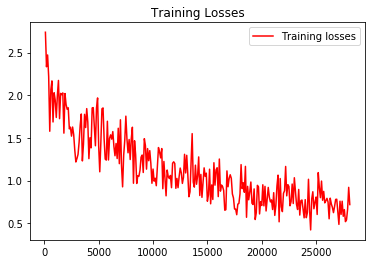

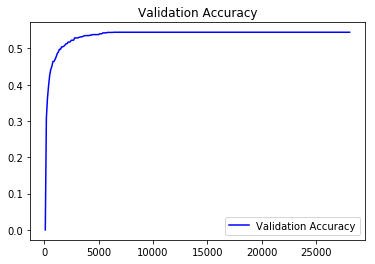

In [24]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = BidirectionalRNN(reversed_dictionary, doc_max_len, num_class)

    train_batches = batch_iter(train_x, train_y, 64, 10)
    num_batches_per_epoch = (len(train_x) - 1) // 64 + 1
    best_accuracy = 0
    
    sess.run(tf.global_variables_initializer())
    model_saver = tf.train.Saver(tf.global_variables())

    losses = []
    val_accuracies = []
    epochs = []
    
    for x_batch, y_batch in train_batches:
        train_feed_dict = {
            model.x: x_batch,
            model.y: y_batch,
            model.keep_prob: 0.8
        }
        _, step, loss = sess.run([model.optimizer, model.global_step, model.loss], feed_dict=train_feed_dict)
        if step % 100 == 0:
            print("In step {0}, The loss is: {1}".format(step, loss))
        if step % 100 == 0:
            valid_batches = batch_iter(valid_x, valid_y, 64, 1)
            sum_accuracy, count = 0, 0
            for valid_x_batch, valid_y_batch in valid_batches:
                valid_feed_dict = {
                    model.x: valid_x_batch,
                    model.y: valid_y_batch,
                    model.keep_prob: 1.0
                }
                accuracy = sess.run(model.accuracy, feed_dict=valid_feed_dict)
                sum_accuracy += accuracy
                count += 1
            temp_accuracy = sum_accuracy / count
            epochs.append(step)
            val_accuracies.append(best_accuracy)
            losses.append(loss)
            print("\n Accuracy = {1}\n".format(step // num_batches_per_epoch, sum_accuracy / count))
            # Save the model that can produce the best accuracy
            if temp_accuracy > best_accuracy:
                best_accuracy = temp_accuracy
                #model_saver.save(sess, "{0}/{1}.ckpt".format("saved_model", "naive"), global_step=step)
    
    print("end.")
    plt.title('Training Losses')
    plt.plot(epochs, losses, 'red', label='Training losses')
    plt.legend()
    
    plt.figure()
    plt.title('Validation Accuracy')
    plt.plot(epochs, val_accuracies, 'blue', label='Validation Accuracy')
    plt.legend()
    
    plt.show()


In [25]:
class AttentionRNN(object):
    def __init__(self, reversed_dict, document_max_len, num_class):
        self.vocabulary_size = len(reversed_dict)
        self.embedding_size = 300
        self.num_hidden = 100
        self.num_layers = 2
        self.learning_rate = 1e-3

        self.x = tf.placeholder(tf.int32, [None, document_max_len], name="x")
        self.x_len = tf.reduce_sum(tf.sign(self.x), 1)
        self.y = tf.placeholder(tf.int32, [None], name="y")
        self.keep_prob = tf.placeholder(tf.float32, [], name="keep_prob")
        self.global_step = tf.Variable(0, trainable=False)

        init_embeddings = tf.random_uniform([self.vocabulary_size, self.embedding_size])
        self.embeddings = tf.get_variable("embeddings", initializer=init_embeddings, trainable=True)
        self.x_emb = tf.nn.embedding_lookup(self.embeddings, self.x)

        fw_cells = [rnn.BasicLSTMCell(self.num_hidden) for _ in range(self.num_layers)]
        bw_cells = [rnn.BasicLSTMCell(self.num_hidden) for _ in range(self.num_layers)]
        fw_cells = [rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob) for cell in fw_cells]
        bw_cells = [rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob) for cell in bw_cells]

        self.rnn_outputs, _, _ = rnn.stack_bidirectional_dynamic_rnn(
            fw_cells, bw_cells, self.x_emb, sequence_length=self.x_len, dtype=tf.float32)

        self.attention_score = tf.nn.softmax(tf.contrib.slim.fully_connected(self.rnn_outputs, 1))
        self.attention_out = tf.squeeze(
            tf.matmul(tf.transpose(self.rnn_outputs, perm=[0, 2, 1]), self.attention_score),
            axis=-1)

        self.logits = tf.contrib.slim.fully_connected(self.attention_out, num_class, activation_fn=None)
        self.predictions = tf.argmax(self.logits, -1, output_type=tf.int32)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        correct_predictions = tf.equal(self.predictions, self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In step 100, The loss is: 3.570420026779175

 Accuracy = 0.16365481894046735

In step 200, The loss is: 3.134782552719116

 Accuracy = 0.2335596378809347

In step 300, The loss is: 2.359339714050293

 Accuracy = 0.2899693822898804

In step 400, The loss is: 2.5075063705444336

 Accuracy = 0.3212526624385541

In step 500, The loss is: 2.8682398796081543

 Accuracy = 0.3497237752611264

In step 600, The loss is: 2.9459023475646973

 Accuracy = 0.36949214586815515

In step 700, The loss is: 2.6028151512145996

 Accuracy = 0.40436967521810685

In step 800, The loss is: 1.9480197429656982

 Accuracy = 0.42127595846645366

In step 900, The loss is: 2.1908020973205566

 Accuracy = 0.43560303514376997

In step 1000, The loss is: 2.0513293743133545

 Accuracy = 0.45795061232182926

In step 1100, The loss is: 2.1230430603027344

 Accuracy = 0.4725272896381232

In step 1200, The loss is: 1.9054478406906128

 Accuracy = 0.46335862619808305

In step 1300, The loss is: 1.8962732553482056

 Accuracy 


 Accuracy = 0.578757321587005

In step 10600, The loss is: 1.0103437900543213

 Accuracy = 0.5879093450479234

In step 10700, The loss is: 0.8027811050415039

 Accuracy = 0.5704373003194888

In step 10800, The loss is: 0.6956006288528442

 Accuracy = 0.5860789403938257

In step 10900, The loss is: 1.296581506729126

 Accuracy = 0.5871439030566535

In step 11000, The loss is: 1.0457631349563599

 Accuracy = 0.5802715654952076

In step 11100, The loss is: 0.8144789934158325

 Accuracy = 0.5846312566877554

In step 11200, The loss is: 0.8656949996948242

 Accuracy = 0.5667931309904153

In step 11300, The loss is: 0.7776570320129395

 Accuracy = 0.5947151225024518

In step 11400, The loss is: 0.7261970043182373

 Accuracy = 0.5837493343665577

In step 11500, The loss is: 0.7070363759994507

 Accuracy = 0.5804046858042574

In step 11600, The loss is: 1.24700129032135

 Accuracy = 0.5768270766773163

In step 11700, The loss is: 0.8794289827346802

 Accuracy = 0.5806542865384501

In step 118


 Accuracy = 0.5587892704687941

In step 20900, The loss is: 0.7550679445266724

 Accuracy = 0.5321818423537782

In step 21000, The loss is: 0.4131934642791748

 Accuracy = 0.5344282481045769

In step 21100, The loss is: 0.23048874735832214

 Accuracy = 0.5462759584664537

In step 21200, The loss is: 0.5460155606269836

 Accuracy = 0.5401025026941452

In step 21300, The loss is: 0.49330902099609375

 Accuracy = 0.5318157614800877

In step 21400, The loss is: 0.36380478739738464

 Accuracy = 0.5391873003194888

In step 21500, The loss is: 0.5010495185852051

 Accuracy = 0.5353933706070287

In step 21600, The loss is: 0.2535366714000702

 Accuracy = 0.557757587859425

In step 21700, The loss is: 0.35422301292419434

 Accuracy = 0.554379659243666

In step 21800, The loss is: 0.4297696352005005

 Accuracy = 0.5563099041533547

In step 21900, The loss is: 0.36533230543136597

 Accuracy = 0.5385882587859425

In step 22000, The loss is: 0.33425813913345337

 Accuracy = 0.5417498669113976

In 

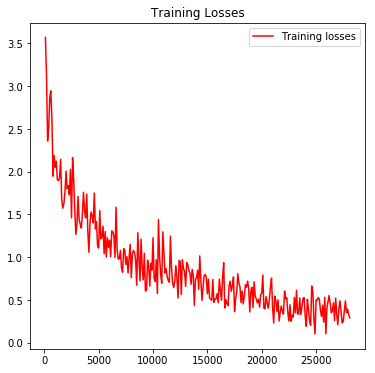

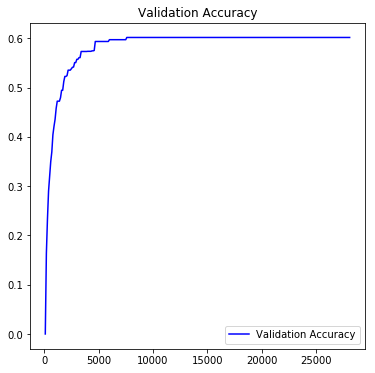

In [29]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = AttentionRNN(reversed_dictionary, doc_max_len, num_class)

    train_batches = batch_iter(train_x, train_y, 64, 10)
    num_batches_per_epoch = (len(train_x) - 1) // 64 + 1
    best_accuracy = 0
    
    sess.run(tf.global_variables_initializer())
    model_saver = tf.train.Saver(tf.global_variables())
    
    losses = []
    val_accuracies = []
    epochs = []

    for x_batch, y_batch in train_batches:
        train_feed_dict = {
            model.x: x_batch,
            model.y: y_batch,
            model.keep_prob: 0.8
        }
        _, step, loss = sess.run([model.optimizer, model.global_step, model.loss], feed_dict=train_feed_dict)
        if step % 100 == 0:
            print("In step {0}, The loss is: {1}".format(step, loss))
        if step % 100 == 0:
            valid_batches = batch_iter(valid_x, valid_y, 64, 1)
            sum_accuracy, count = 0, 0
            for valid_x_batch, valid_y_batch in valid_batches:
                valid_feed_dict = {
                    model.x: valid_x_batch,
                    model.y: valid_y_batch,
                    model.keep_prob: 1.0
                }
                accuracy = sess.run(model.accuracy, feed_dict=valid_feed_dict)
                sum_accuracy += accuracy
                count += 1
            temp_accuracy = sum_accuracy / count
            epochs.append(step)
            val_accuracies.append(best_accuracy)
            losses.append(loss)
            print("\n Accuracy = {1}\n".format(step // num_batches_per_epoch, sum_accuracy / count))
            # Save the model that can produce the best accuracy
            if temp_accuracy > best_accuracy:
                best_accuracy = temp_accuracy
                #model_saver.save(sess, "{0}/{1}.ckpt".format("saved_model", "naive"), global_step=step)
    
    print("end.")
    plt.title('Training Losses')
    plt.plot(epochs, losses, 'red', label='Training losses')
    plt.legend()
    
    plt.figure()
    plt.title('Validation Accuracy')
    plt.plot(epochs, val_accuracies, 'blue', label='Validation Accuracy')
    plt.legend()
    
    plt.show()
